<a href="https://colab.research.google.com/github/varungole/Kannada-MIST/blob/main/Kannada_MIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [55]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()
test_temp = test

In [56]:
print(f"Training Dataset: \n\tnumber of images: {train.shape[0]}\n\tnumber of features: {train.shape[1]}")
print(f"\tmissing data: {train.isnull().sum().sum()}")

Training Dataset: 
	number of images: 60000
	number of features: 785
	missing data: 0


In [57]:
labels = train.label.value_counts().index # Get the class names
counts = train.label.value_counts() # Get the number of rows by class

print(f"Classes: {labels}")
print(f"Number of images per label: {counts}")

Classes: Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')
Number of images per label: 0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64


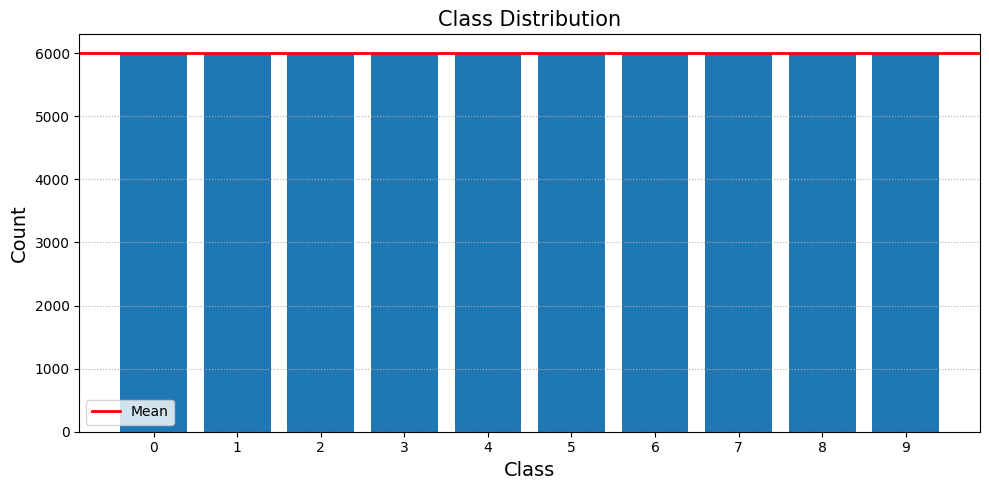

In [58]:
plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Class', fontsize=14) # Add text to the X-axis
plt.ylabel('Count', fontsize=14) # Add text to the Y axis
plt.title('Class Distribution', fontsize=15) # Add a header about class distribution

# We add a line to show the uniformity of the distribution of features
plt.axhline(counts.mean(), color='red', linewidth=2, label='Mean')

plt.legend()
plt.grid(axis='y', linestyle='dotted')

plt.tight_layout()
plt.show()

In [59]:
X = train.drop('label' , axis = 1)
Y = test.drop('id' , axis = 1)


In [60]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
X = np.array(X)
Y = np.array(Y)

In [62]:
#now we set datatype to float
X = X.astype('float32')
X.shape
Y = Y.astype('float32')
Y.shape

(5000, 784)

In [63]:
X.shape


(60000, 784)

In [64]:
#Normalize
X = X/ 255.0
Y = Y/ 255.0

In [65]:
#images are in graysscale, we convert them to RGB
X = cv2.cvtColor(X , cv2.COLOR_GRAY2RGB)
X.shape
Y = cv2.cvtColor(Y , cv2.COLOR_GRAY2RGB)
Y.shape

(5000, 784, 3)

In [66]:
X.shape

(60000, 784, 3)

In [67]:
Y.shape

(5000, 784, 3)

In [68]:
X = X.reshape(-1 , 28 , 28 , 3)

In [69]:
Y = Y.reshape(-1 , 28 , 28 , 3)

In [70]:
y = train.label

In [71]:
y

0        0
1        1
2        2
3        3
4        4
        ..
59995    5
59996    6
59997    7
59998    8
59999    9
Name: label, Length: 60000, dtype: int64


Example of a training image for label :0


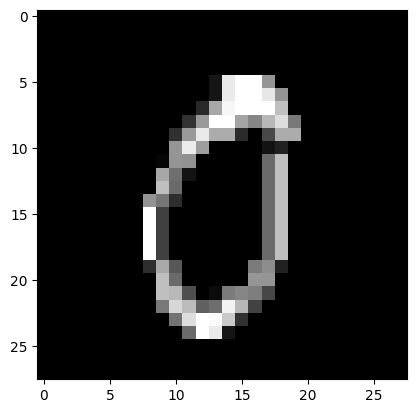

In [72]:
print(f"\nExample of a training image for label :{y[0]}")
train_img_plot = plt.imshow(X[0])
plt.show()

In [73]:
X_train , X_val , y_train , y_val = train_test_split(X, y, test_size=0.20, random_state=16)

In [74]:
X_train_t = torch.from_numpy(X_train).float()

In [75]:
y_train_t =  torch.from_numpy(y_train.values)

In [76]:
train_tensor = TensorDataset(X_train_t, y_train_t)


In [77]:
X_val_t =  torch.from_numpy(X_val).float()
y_val_t =  torch.from_numpy(y_val.values)
val_tensor = TensorDataset(X_val_t, y_val_t)

X_test_t = torch.from_numpy(Y).float()

In [78]:
batch_size = 16

In [79]:
# Load image into data generator
train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(X_test_t, batch_size=batch_size, num_workers=2, shuffle=False)

loaders = {"train": train_loader, "valid": val_loader}

In [80]:
#Let’s check to see if torch.cuda or torch.backends.mps are available, otherwise we use the CPU.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [81]:
X_train_t.size()

torch.Size([48000, 28, 28, 3])

In [82]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
            )

    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_relu_stack(x)
        return output


In [83]:
model = NeuralNetwork().to(device)


In [84]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [85]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [86]:

def train_loop(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)

    # set the model to training mode
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch% 100 == 0:
            loss, current  = loss, (batch + 1)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [87]:

def test_loop(data_loader, model, loss_fn):
    # set the model to evaluation mode
    model.eval()

    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [88]:

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(val_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.290768  [   16/48000]
loss: 2.293032  [ 1616/48000]
loss: 2.296067  [ 3216/48000]
loss: 2.279735  [ 4816/48000]
loss: 2.283983  [ 6416/48000]
loss: 2.267688  [ 8016/48000]
loss: 2.257553  [ 9616/48000]
loss: 2.255929  [11216/48000]
loss: 2.233661  [12816/48000]
loss: 2.233506  [14416/48000]
loss: 2.218312  [16016/48000]
loss: 2.214775  [17616/48000]
loss: 2.219078  [19216/48000]
loss: 2.186092  [20816/48000]
loss: 2.178630  [22416/48000]
loss: 2.161965  [24016/48000]
loss: 2.168508  [25616/48000]
loss: 2.132777  [27216/48000]
loss: 2.169814  [28816/48000]
loss: 2.134962  [30416/48000]
loss: 2.098353  [32016/48000]
loss: 2.113644  [33616/48000]
loss: 2.028250  [35216/48000]
loss: 2.038045  [36816/48000]
loss: 1.967629  [38416/48000]
loss: 1.952371  [40016/48000]
loss: 1.987583  [41616/48000]
loss: 1.906048  [43216/48000]
loss: 1.834355  [44816/48000]
loss: 1.832495  [46416/48000]
Test Error: 
 Accuracy: 76.9%, Avg loss: 1.792093 

Epoch 2


In [89]:
# Prediction
logits = model(X_test_t)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3, 0, 2,  ..., 1, 6, 3])



Test image prediction
Prediction: 6


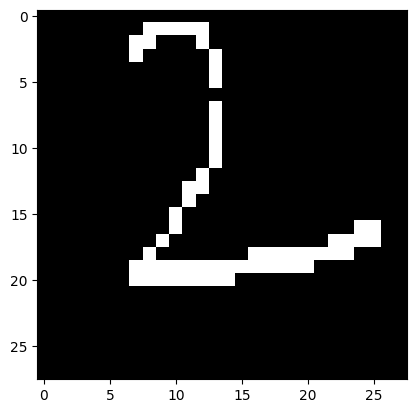

In [91]:

results = pd.Series(y_pred,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("mnist_prediction.csv",index=False)